In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas_datareader import data as wb
import datetime
import scipy.optimize as sco

start = datetime.datetime(2018, 1, 1)
end = datetime.datetime(2019, 6, 15)

In [2]:
assets = ['PETR4.SA','ABEV3.SA','CIEL3.SA','ITUB4.SA','^BVSP']
portfolio = pd.DataFrame()

for t in assets:   
    portfolio[t] = wb.DataReader(t,data_source='yahoo',start='2012-1-1',end='2019-6-20')['Adj Close']

sec_ret=np.log(portfolio/portfolio.shift(1))
sec_ret.tail()

,PETR4.SA,ABEV3.SA,CIEL3.SA,ITUB4.SA,^BVSP
Date,,,,,
2019-06-17,0.001846,0.009029,0.003026,-0.001178,-0.004262
2019-06-18,0.012464,0.013947,0.019447,0.025590,0.018079
2019-06-19,0.002547,0.008276,0.014706,0.015668,0.009003
2019-06-20,0.000000,0.000000,NaN,NaN,0.000000
2019-06-21,0.027242,0.013643,NaN,NaN,0.016905


## Matriz de covariância

In [3]:
# Vamos assumir 250 dias ao ano negociados.
covariance=sec_ret.cov()*250
covariance

,PETR4.SA,ABEV3.SA,CIEL3.SA,ITUB4.SA,^BVSP
PETR4.SA,0.229935,0.032758,0.042141,0.086051,0.083885
ABEV3.SA,0.032758,0.052819,0.021265,0.026578,0.024687
CIEL3.SA,0.042141,0.021265,0.106951,0.031632,0.029463
ITUB4.SA,0.086051,0.026578,0.031632,0.092219,0.055982
^BVSP,0.083885,0.024687,0.029463,0.055982,0.050850


## Índice Beta: Como é Calculado?

A fórmula do Índice Beta é bem simples:

Beta = Covariância entre o Retorno do Ativo e do Mercado / Variância do Retorno do Mercado

In [4]:
marketcov = covariance.iloc[:,-1]
market_var=sec_ret['^BVSP'].var()*250
marketcov

PETR4.SA    0.083885
ABEV3.SA    0.024687
CIEL3.SA    0.029463
ITUB4.SA    0.055982
^BVSP       0.050850
Name: ^BVSP, dtype: float64

In [5]:
market_var

0.050849839065064135

In [6]:
betam = marketcov/market_var
betam

PETR4.SA    1.649660
ABEV3.SA    0.485488
CIEL3.SA    0.579403
ITUB4.SA    1.100926
^BVSP       1.000000
Name: ^BVSP, dtype: float64

In [7]:
media = sec_ret.mean()*250
media[-1]

0.06880820386286685

In [8]:
# Expected Return
premio = sec_ret['^BVSP'].mean()*250 - 0.065
Exp_ret= 0.065+betam*premio
Exp_ret

PETR4.SA    0.071282
ABEV3.SA    0.066849
CIEL3.SA    0.067206
ITUB4.SA    0.069193
^BVSP       0.068808
Name: ^BVSP, dtype: float64

## Índice de Sharpe: Como é Calculado?

IS = ( Ri -Rf ) / (σi )

Onde:

    IS = Índice de Sharpe
    Ri = Retorno do Ativo
    Rf = Retorno Livre de Riso ( Risk-Free )
    σi = Risco do Ativo ( a letra grega sigma representa volatilidade )


In [9]:
# Calculation os Sharpe ratio
Rf = 0.065   #SELIC witch risk free
sharpes = []
sigma = (sec_ret.std()*(250**0.5))
sharpe = (Exp_ret-Rf)/sigma
sharpe

PETR4.SA    0.013101
ABEV3.SA    0.008045
CIEL3.SA    0.006747
ITUB4.SA    0.013806
^BVSP       0.016888
dtype: float64

In [10]:
Exp_ret

PETR4.SA    0.071282
ABEV3.SA    0.066849
CIEL3.SA    0.067206
ITUB4.SA    0.069193
^BVSP       0.068808
Name: ^BVSP, dtype: float64

In [11]:
Exp_ret-Rf

PETR4.SA    0.006282
ABEV3.SA    0.001849
CIEL3.SA    0.002206
ITUB4.SA    0.004193
^BVSP       0.003808
Name: ^BVSP, dtype: float64

In [12]:
sigma

PETR4.SA    0.479515
ABEV3.SA    0.229825
CIEL3.SA    0.327033
ITUB4.SA    0.303676
^BVSP       0.225499
dtype: float64

## CAPM

ERi = Expected return of investment

Rf = Risk-free rate

βi = Beta of the investment

ERm = Expected return of market

(ERm - Rf) = Market risk premium

ERi = Rf + βi(ERm - Rf)


In [15]:
def min_risk(shares):
    risk = np.dot(marketcov[:4]*250, np.power(shares, 2))
    return np.array(risk)

In [16]:
shares = [0.4, 0.3, 0.2, 0.1]
risk = np.dot(shares, np.dot(marketcov[:4]*250, shares))
np.dot(risk, [1,1,1,1])

13.112692419060181

In [17]:
np.dot(marketcov[:4]*250, shares)/250

0.052450769676240724

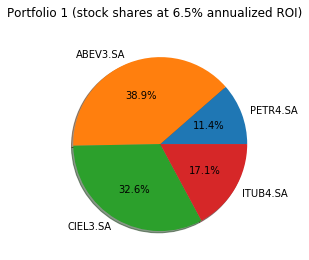

In [89]:
min_ret = .067 # 6.7% rate
cons = ({'type': 'eq', 'fun': lambda x: np.sum(x)-1}, {'type': 'ineq', 'fun': lambda x: np.dot(x, Exp_ret[:4])-min_ret})
bnds = [(0, 1)]*(len(media)-1)

opts = sco.minimize(min_risk, (len(media)-1)*[(len(media)-1)**-1,], method='SLSQP', bounds = bnds, constraints=cons)

x = sec_ret.columns[:4]
y = opts['x']

plt.pie(y, labels=x, autopct='%1.1f%%', shadow=True)
plt.suptitle("Portfolio 1 (stock shares at 6.5% annualized ROI)")
plt.savefig("report/Figure_9.png")

In [91]:
np.sum(np.dot(opts['x'], (Exp_ret-Rf)[:4])/np.dot(opts['x'], sigma[:4]))

0.012713706743512151

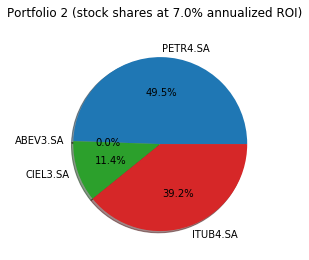

In [90]:
min_ret = .07 # 7% rate
cons = ({'type': 'eq', 'fun': lambda x: np.sum(x)-1}, {'type': 'ineq', 'fun': lambda x: np.dot(x, Exp_ret[:4])-min_ret})

opts = sco.minimize(min_risk, (len(media)-1)*[(len(media)-1)**-1,], method='SLSQP', bounds = bnds, constraints=cons)

x = sec_ret.columns[:4]
y = opts['x']

plt.pie(y, labels=x, autopct='%1.1f%%', shadow=True)
plt.suptitle("Portfolio 2 (stock shares at 7.0% annualized ROI)")
plt.savefig("report/Figure_10.png")